# Install dependencies

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Import librairies

In [32]:
import os
import argparse
import pandas as pd
import numpy as np
import functions.preprocessing
import functions.pls
import functions.snapshots
from sklearn.cross_decomposition import PLSCanonical, CCA
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle
from sklearn.utils import resample
import matplotlib.pyplot as plt
from scipy import stats 
from pingouin import ancova
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve


# Load data

In [33]:
df_brain = pd.read_csv('/home/leonie/Documents/data/pisa/sMRI/sulci_morphometry_measurements/per_measurement/opening.csv', index_col=0)
df_cogn = pd.read_csv('/home/leonie/Documents/data/pisa/cognitive_scores/neuropsych.csv', index_col=0)
df_info = pd.read_csv('/home/leonie/Documents/data/pisa/cognitive_scores/demographics.csv', index_col=0)

group_col = 'Group'
age_col = 'Age'
sex_col = 'Sex'
drop_rate = 0.5
regress_out_confounds = False
train_hc_only = True
mean = True
cca = False
n_mode = 5

# Preprocessing

In [4]:
df_brain, df_cogn, df_info, Xbrain, Ycogn = functions.preprocessing.preprocessing(
    df_brain, df_cogn, df_info, 
    group_col=group_col, age_col=age_col, sex_col=sex_col,
    drop_rate=drop_rate, regress_out_confounds=regress_out_confounds,
    train_hc_only=train_hc_only, mean=mean, verbose=True)

Averaging left/right measurements...
Keep subjects present in both datasets...
245 subjects selected.
Drop features with more than 50.0% missing values...
3 brain features dropped: ['F.C.L.r.sc.ant.', 'S.GSM.', 'S.intraCing.'] 
0 cognitives features dropped: []
Drop subjects with more than 50.0% missing values...
0 dropped subjects
Remove subjects with unknown Group and Age...
245 subjects (202+43)
Remove outliers...
242 subjects (199+43)
Match age...
226 subjects (191+35)
Match sex...
225 subjects (190+35)
Train on healthy participants only...

N | 190 HC | 35 CC
Age | 61 [49-73] | 63 [51-72]
T-test on age means | p=0.10, stat=-1.7e+00
Males N | 49 | 15
Fisher exact test (sex) | p=0.065, odds-ratio=0.46



# Pipeline

In [5]:
if cca:
    print('Using CCA...')
    pipeline = functions.pls.PLSPipeline(CCA(n_components=n_mode, max_iter=1000),
                           Ximputer=SimpleImputer(strategy="mean"),
                           Yimputer=SimpleImputer(strategy="mean"))
    score_func = np.corrcoef
else:
    print('Using Canonical PLS...')
    pipeline = functions.pls.PLSPipeline(PLSCanonical(n_components=n_mode, max_iter=1000),
                           Ximputer=SimpleImputer(strategy="mean"),
                           Yimputer=SimpleImputer(strategy="mean"))
    score_func = np.cov

Using Canonical PLS...


# 1. Are the modes robust?

## Run permutation tests

In [6]:
nperm = 1000

print(f'Running {nperm} permutation tests...')
x_scores, y_scores = pipeline.fit_transform(Xbrain, Ycogn)
n_comp = pipeline.PLS.n_components
ref_score = np.diag(score_func(
    x_scores, y_scores, rowvar=False)[:n_comp, n_comp:])

scores = []
for i in range(nperm):
    X = Xbrain
    Y = shuffle(Ycogn, random_state=i)
    x_scores, y_scores = pipeline.fit_transform(X, Y)
    scores.append(np.diag(score_func(
        x_scores, y_scores, rowvar=False)[:n_comp, n_comp:]))
scores = np.array(scores)

Running 1000 permutation tests...


## Print results

In [7]:
def print_pval(p):
    if p == 0:
        pstr = '<0.001'
    elif p == 1:
        pstr = '>0.99'
    elif p < 0.001:
        pstr = f'={p:.1e}'
    elif p < 0.01:
        pstr = f'={p:.4f}'
    elif p < 0.1:
        pstr = f'={p:.3f}'
    else:
        pstr = f'={p:.2f}'
    return pstr

p = 0.05
scores = np.array(scores)
up_list = []
print()
pvals, zcov = [], []
for mode in range(n_comp):
    sc = ref_score[mode]
    zsc = (sc-np.mean(scores[:, 0]))/np.std(scores[:, 0])
    up = np.quantile(scores[:, 0], 1-p)
    up_list.append(up)
    pvals.append(sum(scores[:, 0] >= sc)/nperm) 
    zcov.append(zsc)
rstr = f'RESULT: 1st mode, p{print_pval(pvals[0])}'
if pvals[0] <= 0.05:
    rstr += f', z={zcov[0]:.2f}; 2nd mode, p{print_pval(pvals[1])}'
print(rstr)



RESULT: 1st mode, p<0.001, z=5.49; 2nd mode, p>0.99


## Plot results

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f7214185550>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f72141853a0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f72141926d0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f7214192a90>}

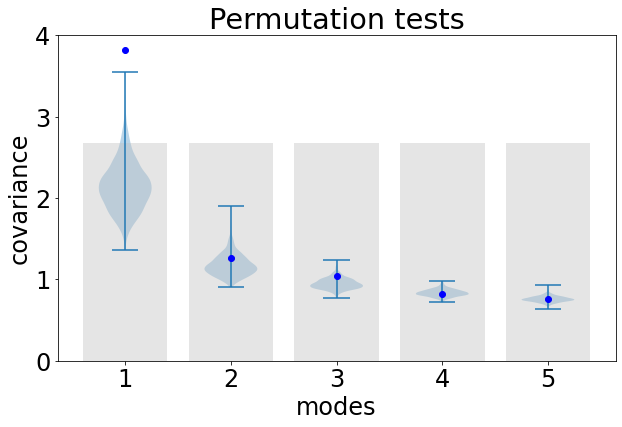

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 24})
plt.bar(range(1, n_comp+1), up_list, color='silver', alpha=0.4)
plt.plot(range(1, n_comp+1), ref_score, 'bo')
plt.xlabel("modes")
if cca:
    plt.ylabel("correlation")
else:
    plt.ylabel("covariance")
plt.title('Permutation tests')
plt.xticks(range(1, n_comp+1))
plt.violinplot(scores)

# 2. What are the contribution of each individual score (a specific cognitive test or brain measurement) to the shared variance?

## New pipeline

In [9]:
n_mode = 1

if cca:
    print('Using CCA...')
    pipeline = functions.pls.PLSPipeline(CCA(n_components=n_mode, max_iter=1000),
                           Ximputer=SimpleImputer(strategy="mean"),
                           Yimputer=SimpleImputer(strategy="mean"))
    score_func = np.corrcoef
else:
    print('Using Canonical PLS...')
    pipeline = functions.pls.PLSPipeline(PLSCanonical(n_components=n_mode, max_iter=1000),
                           Ximputer=SimpleImputer(strategy="mean"),
                           Yimputer=SimpleImputer(strategy="mean"))
    score_func = np.cov

Using Canonical PLS...


## Bootstraping tests

In [10]:
nboot = 1000

print(f'Running {nboot} bootstrapping tests...')
np.random.seed(0)
Xt, Yt = pipeline.fit_transform(Xbrain, Ycogn)
    
y_loadings, x_loadings = [], []
for i in range(nboot):
    Xr, Yr = resample(Xbrain, Ycogn)
    Xrt, Yrt = pipeline.fit_transform(Xr, Yr)
    y_loadings.append(pipeline.PLS.y_loadings_)
    x_loadings.append(pipeline.PLS.x_loadings_)
x_loadings = np.array(x_loadings)
y_loadings = np.array(y_loadings)

Running 1000 bootstrapping tests...


## Print results

In [11]:
for comp in range(pipeline.PLS.n_components):
    print(f'===== COGNITION - MODE {comp} =====')
    for mean_weight, std_weight, var in sorted(zip(
      np.mean(y_loadings, axis=0)[:, comp],
      np.std(y_loadings, axis=0)[:, comp], Ycogn.columns)):
        print(f'{mean_weight:.3f} +/- {std_weight:.3f} {var}')
    print()

for comp in range(pipeline.PLS.n_components):
    print(f'===== BRAIN - MODE {comp} =====')
    for mean_weight, std_weight, var in sorted(zip(
      np.mean(x_loadings, axis=0)[:, comp],
      np.std(x_loadings, axis=0)[:, comp], Xbrain.columns)):
        print(f'{mean_weight:.3f} +/- {std_weight:.3f} {var}')
    print()

===== COGNITION - MODE 0 =====
-0.354 +/- 0.049 E.Stroop: colour naming reaction time *(-1)
-0.290 +/- 0.062 E.Stroop: word colour naming reaction time *(-1)
-0.285 +/- 0.076 M.RAVLT: total learned trial 1 to trial 5
-0.266 +/- 0.087 M.RAVLT: delayed free recall (List A)
-0.264 +/- 0.085 M.RAVLT: immediate free recall (List A)
-0.243 +/- 0.055 M.RAVLT: list learning trial 1 (List B)
-0.236 +/- 0.056 L.Best Holiday: total narrative words
-0.229 +/- 0.054 E.FAS: total correct
-0.223 +/- 0.069 E.TEA Telephone Search: time per target score *(-1)
-0.215 +/- 0.048 L.Animal: total correct
-0.211 +/- 0.057 L.Cookie Theft: total narrative words
-0.209 +/- 0.073 E.Stroop: colour naming correct
-0.196 +/- 0.061 M.RAVLT: list learning trial 1 (List A)
-0.193 +/- 0.052 S.TASIT-S: part B total correct
-0.190 +/- 0.084 M.RAVLT: proportion hits to false positives
-0.175 +/- 0.064 E.Stroop: dot colour naming reaction time *(-1)
-0.175 +/- 0.061 L.Oz beach scene: total narrative words
-0.157 +/- 0.086 E

## Plot results

In [12]:
def boot_plot(mode, loadings, columns, fname):
    means = [m if up*down > 0 else 0 for m, up, down in zip(
        np.mean(loadings, axis=0)[:, mode],
        np.percentile(loadings, 97.5, axis=0)[:, mode],
        np.percentile(loadings, 2.5, axis=0)[:, mode])]
    full_labels = [l for m, l in sorted(zip(means, columns)) if m != 0]
    scores = [m for m in sorted(means) if m != 0]
    colors, labels = [], []
    for l in full_labels:
        if l.startswith('M.'):
            colors.append('lightcoral')
            labels.append(l[2:])
        elif l.startswith('L.'):
            colors.append('lightgreen')
            labels.append(l[2:])
        elif l.startswith('E.'):
            colors.append('lightblue')
            labels.append(l[2:])
        else:
            colors.append('plum')
            labels.append(l)

    plt.rcParams.update({'font.size': 8})
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax1 = ax.twinx()
    ax1.barh(range(len(labels)), scores, 0.9, color=colors, align='center')
    ax1.set_yticks(range(len(labels)))
    ax1.set_yticklabels(labels)
    from matplotlib.patches import Patch
    if len(set(colors)) > 1:
        legend_elements = [Patch(facecolor='lightblue', label='Executive Functions'),
                           Patch(facecolor='lightcoral', label='Memory'),
                           Patch(facecolor='lightgreen', label='Language'),
                           Patch(facecolor='plum', label='Other')]
        ax1.legend(handles=legend_elements, loc='best')
    ax1.set_ylim(-0.5, len(labels)-0.5)
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["left"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    fig.tight_layout()

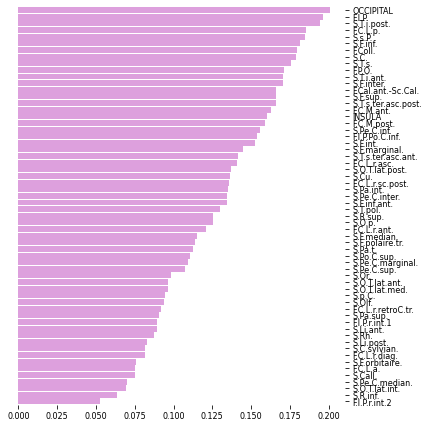

In [13]:
boot_plot(mode=0, loadings=x_loadings, columns=Xbrain.columns, fname='brain')

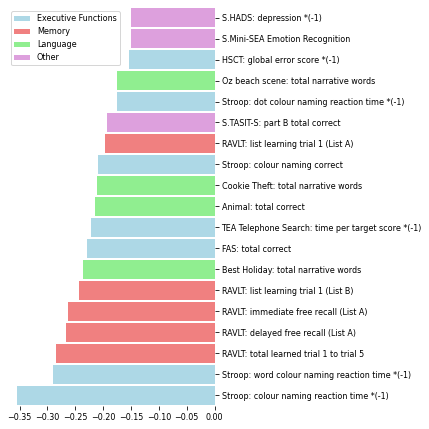

In [14]:
boot_plot(mode=0, loadings=y_loadings, columns=Ycogn.columns, fname='cogn')

## Sulci snapshots

In [15]:
figure_folder = '/tmp'

scores = [m if up*down > 0 else 0 for m, up, down in zip(
    np.mean(x_loadings, axis=0)[:, 0],
    np.percentile(x_loadings, 97.5, axis=0)[:, 0],
    np.percentile(x_loadings, 2.5, axis=0)[:, 0])]
dict_sulcus = {s+'_left': x for s,x in zip(Xbrain.columns, scores) if x!=0}
dict_reg = {0 : [0.5, -0.5, -0.5, 0.5], 1 : [0.5, 0.5, 0.5, 0.5]}
for reg in [0, 1]:
    functions.snapshots.view_sulcus_scores(
        dict_sulcus, side='left', reg_q=dict_reg[reg],
        minVal=0, maxVal=0.2, 
        snapshot=os.path.join(
            figure_folder, 
            f'brain_loadings_mode{mode}_view{reg}.png'))

print(f'Figures saved in {figure_folder}.')

XSOCK=/tmp/.X11-unix && XAUTH=/tmp/.docker.xauth && xauth nlist :0 | sed -e 's/^..../ffff/' | xauth -f $XAUTH nmerge - && docker run --rm -v /tmp//brain_loadings_mode4_view0.csv:/home//brain_loadings_mode4_view0.csv:  -v /tmp:/home/snapshot: -v $XSOCK:$XSOCK -v $XAUTH:$XAUTH -e XAUTHORITY=$XAUTH 9051257e588b /bin/bash -c ". /home/brainvisa/build/bug_fix/bin/bv_env.sh /home/brainvisa/build/bug_fix && python ./snapshots.py -c /home//brain_loadings_mode4_view0.csv -o /home/snapshot/brain_loadings_mode4_view0.png -s left -r 0 -p 'Blue-Red-fusion' -b white -m 0 -n 0.2"

XSOCK=/tmp/.X11-unix && XAUTH=/tmp/.docker.xauth && xauth nlist :0 | sed -e 's/^..../ffff/' | xauth -f $XAUTH nmerge - && docker run --rm -v /tmp//brain_loadings_mode4_view1.csv:/home//brain_loadings_mode4_view1.csv:  -v /tmp:/home/snapshot: -v $XSOCK:$XSOCK -v $XAUTH:$XAUTH -e XAUTHORITY=$XAUTH 9051257e588b /bin/bash -c ". /home/brainvisa/build/bug_fix/bin/bv_env.sh /home/brainvisa/build/bug_fix && python ./snapshots.py -c 

# 3. Plot age effect

## Columns name

In [16]:
amyloid_col = 'Amyloid'
apoe_col = 'APOEe4'
prs_col = 'PRS_noAPOE'

## Functions definition

In [17]:
def plot_age_effect(X, Y, df_info):
    plt.style.use('default')
    plt.rcParams.update({'font.size': 25})
    fig, axes = plt.subplots(4, 4, figsize=(30, 20), sharey='row',
                             gridspec_kw={'width_ratios': [4, 2, 4, 2]})
    # sex
    print('------ SEX')
    col={0:'salmon', 1:'lightseagreen'}
    dict_label={0:'Female', 1:'Male'}
    covar = [age_col]
    axes = plot_comparison(X[df_info[group_col] == 1], Y[df_info[group_col] == 1], 
                           df_info[df_info[group_col] == 1], sex_col, covar,
                           axes, 0, dict_label, col, mode=0)
    axes[0, 0].legend(loc='upper left')
    axes[0, 2].set_title('Sulcal Width')
    axes[0, 0].set_title('Cognitive Scores')
    axes[0, 0].set_ylabel('(a)', rotation=0, fontsize=40)
    axes[0, 0].yaxis.labelpad = 30
    # groups
    print('------ GROUPS')
    col={1:'steelblue', 2:'tab:orange', 3:'red'}
    dict_label={1:'HC', 2:'MCI', 3:'AD'}
    covar = [age_col, sex_col]
    axes = plot_comparison(X, Y, df_info, group_col, covar, 
                           axes, 1, dict_label, col, mode=0)
    axes[1, 0].legend(loc='lower left', ncol=3)
    axes[1, 0].set_ylabel('(b)', rotation=0, fontsize=40)
    axes[1, 0].yaxis.labelpad = 30
    # amyloid
    print('------ AMYLOID')
    col={'Negative':'sandybrown', 'Positive':'darkseagreen'}
    dict_label={'Negative':'Aβ negative', 'Positive':'Aβ positive'}
    covar = [age_col, sex_col]
    axes = plot_comparison(X[df_info[group_col] == 1],
                           Y[df_info[group_col] == 1], 
                           df_info[df_info[group_col] == 1], 
                           amyloid_col, covar,
                           axes, 2, dict_label, col, mode=0)
    axes[2, 0].legend(loc='upper left')
    axes[2, 0].set_ylabel('(c)', rotation=0, fontsize=40)
    axes[2, 0].yaxis.labelpad = 30
    # apoe
    print('------ APOE')
    col={0:'orchid', 4:'lightskyblue'}
    dict_label={0:'no APOE ε4', 4:'APOE ε4'}
    colname = apoe_col
    covar = [age_col, sex_col]
    if prs_col in df_info.columns:
        covar = covar + [prs_col]
    if 'Twin' in df_info.columns:
        df_twin = df_info[df_info.Twin == 'MZ']
        twin_list = []
        for idx in df_twin.index:
            if not df_twin.loc[idx, 'Twin_ID'] in twin_list:
                twin_list.append(idx)
        rm_list = [idx for idx in df_twin.index if idx not in twin_list]
        select = np.array([True if row[group_col] == 1 and idx not in rm_list else False for idx, row in df_info.iterrows()])
    else:
        select = np.array(df_info[group_col] == 1)
    axes = plot_comparison(X[select], Y[select], 
                           df_info[select], colname, covar,
                           axes, 3, dict_label, col, mode=0)
    axes[3, 0].legend(loc='upper left')
    axes[3, 0].set_xlabel("age")
    axes[3, 2].set_xlabel("age")
    axes[3, 0].yaxis.labelpad = 30
    axes[3, 0].set_ylabel('(d)', rotation=0, fontsize=40)
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.tight_layout()
    return fig

def print_pval(p):
    if p == 0:
        pstr = '<0.001'
    elif p == 1:
        pstr = '>0.99'
    elif p < 0.001:
        pstr = f'={p:.1e}'
    elif p < 0.01:
        pstr = f'={p:.4f}'
    elif p < 0.1:
        pstr = f'={p:.3f}'
    else:
        pstr = f'={p:.2f}'
    return pstr

def plot_comparison(X, Y, df_info, between, covar, axes, line,
                    dict_label, col, mode=0):
    groups = df_info[between]
    lv = 'Brain'
    s = 25 if len(df_info)>500 else 75
    pvals = []
    for ax, axh, x in zip([axes[line, 2], axes[line, 0]], 
                          [axes[line, 3], axes[line, 1]], 
                          [X, Y]):
        x = np.array(x)[~pd.isnull(groups)]
        y = np.array(df_info.Age)[~pd.isnull(groups)]
        gr = np.array(groups)[~pd.isnull(groups)]
        grs = list(set(gr))
        for i in set(gr):
            path = ax.scatter(y[gr == i], x[gr == i],
                              label=dict_label[i], marker="o",
                              c=col[i], s=s)
            Xg, Yg = x[gr == i], y[gr == i]
            linreg = stats.linregress(Yg[~np.isnan(Yg)],
                                      Xg[~np.isnan(Yg)])
            ax.plot(y, linreg.intercept + linreg.slope*y, 
                    color=path.get_facecolors()[0].tolist(),
                    linewidth=4)
        data = [list(x[gr == g]) for g in sorted(list(set(gr)))]
        labels = [dict_label[g] for g in sorted(list(set(gr)))]
        colors = [col[g] for g in sorted(list(set(gr)))]
        bplot = axh.boxplot(data, notch=True, vert=True, widths=0.3,
                            patch_artist=True, whis=100, labels=labels)
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
        df = df_info[covar + [between]][~pd.isnull(groups)]
        df['dv'] = x
        if len(set(gr)) > 2:
            # test mean difference
            for g, th in zip([[1, 2], [2, 3], [1, 3]], [0, 5, 15]):
                anc = ancova(data=df[df_info[group_col].isin(g)], dv='dv',
                             covar=covar, between=between)
                print(f'{lv}: mean difference {dict_label[g[0]]} vs. {dict_label[g[1]]} p{print_pval(anc.loc[0, "p-unc"])}')
                if anc.loc[0, 'p-unc'] < 0.05:
                    star = '**' if anc.loc[0, 'p-unc'] < 0.001 else '*'
                    axh.plot([g[0] + 0.25, g[0] + 0.25, g[1] - 0.25, g[1] - 0.75],
                              [th, th, th, th], linewidth=2, color='k')
                    axh.text(sum(g)/2, th+1, star, ha='center', va='bottom', color='k')
            # test slope difference
            for grs in [[1, 2], [2, 3], [1, 3]]:
                tstat, pval = test_slopes_anova(y[gr==grs[0]], x[gr==grs[0]], 
                                          y[gr==grs[1]], x[gr==grs[1]])
                print(f'{lv}: slope difference {dict_label[grs[0]]} vs. {dict_label[grs[1]]} p{print_pval(pval)}')
        else:
            grs = list(set(gr))
            # test mean difference
            anc = ancova(data=df, dv='dv', covar=covar, between=between)
            print(f'{lv}: mean difference p{print_pval(anc.loc[0, "p-unc"])}')
            if anc.loc[0, 'p-unc'] < 0.05:
                star = '**' if anc.loc[0, 'p-unc'] < 0.001 else '*'
                axh.plot([1.25,1.25, 1.75,1.75], [0, 0, 0, 0], linewidth=2, color='k')
                axh.text(1.5, 1, star, ha='center', va='bottom', color='k')
            # test slope difference
            tstat, pval = test_slopes_anova(y[gr==grs[0]], x[gr==grs[0]], 
                                            y[gr==grs[1]], x[gr==grs[1]])
            print(f'{lv}: slope difference p{print_pval(pval)}')
        lv = 'Cognition'
    return axes

def test_slopes_anova(X1, Y1, X2, Y2):
    df1 = pd.DataFrame({'x':X1, 'y':Y1})
    df1['group'] = 1
    df2 = pd.DataFrame({'x':X2, 'y':Y2})
    df2['group'] = 2
    df = pd.concat([df1, df2], ignore_index=True)
    df['interaction'] = [df.loc[idx, 'x'] if df.loc[idx, 'group'] == 1 else 0 for idx in df.index]
    anc = ancova(dv='y', covar=['x', 'interaction'], between='group', data=df)
    anc.index = anc.Source
    return anc.loc['interaction', 'F'], anc.loc['interaction', 'p-unc']

## Figure

------ SEX
Brain: mean difference p=1.2e-06
Brain: slope difference p=0.97
Cognition: mean difference p=1.6e-06
Cognition: slope difference p=0.98
------ GROUPS
Brain: mean difference HC vs. MCI p=4.4e-05
Brain: mean difference MCI vs. AD p=0.016
Brain: mean difference HC vs. AD p=2.2e-24
Brain: slope difference HC vs. MCI p=0.73
Brain: slope difference MCI vs. AD p=0.63
Brain: slope difference HC vs. AD p=0.44
Cognition: mean difference HC vs. MCI p=1.9e-14
Cognition: mean difference MCI vs. AD p=0.0048
Cognition: mean difference HC vs. AD p=7.9e-37
Cognition: slope difference HC vs. MCI p=0.43
Cognition: slope difference MCI vs. AD p=0.61
Cognition: slope difference HC vs. AD p=0.022
------ AMYLOID
Brain: mean difference p=0.85
Brain: slope difference p=0.24
Cognition: mean difference p=0.0019
Cognition: slope difference p=6.6e-04
------ APOE
Brain: mean difference p=0.42
Brain: slope difference p=0.62
Cognition: mean difference p=0.45
Cognition: slope difference p=0.88


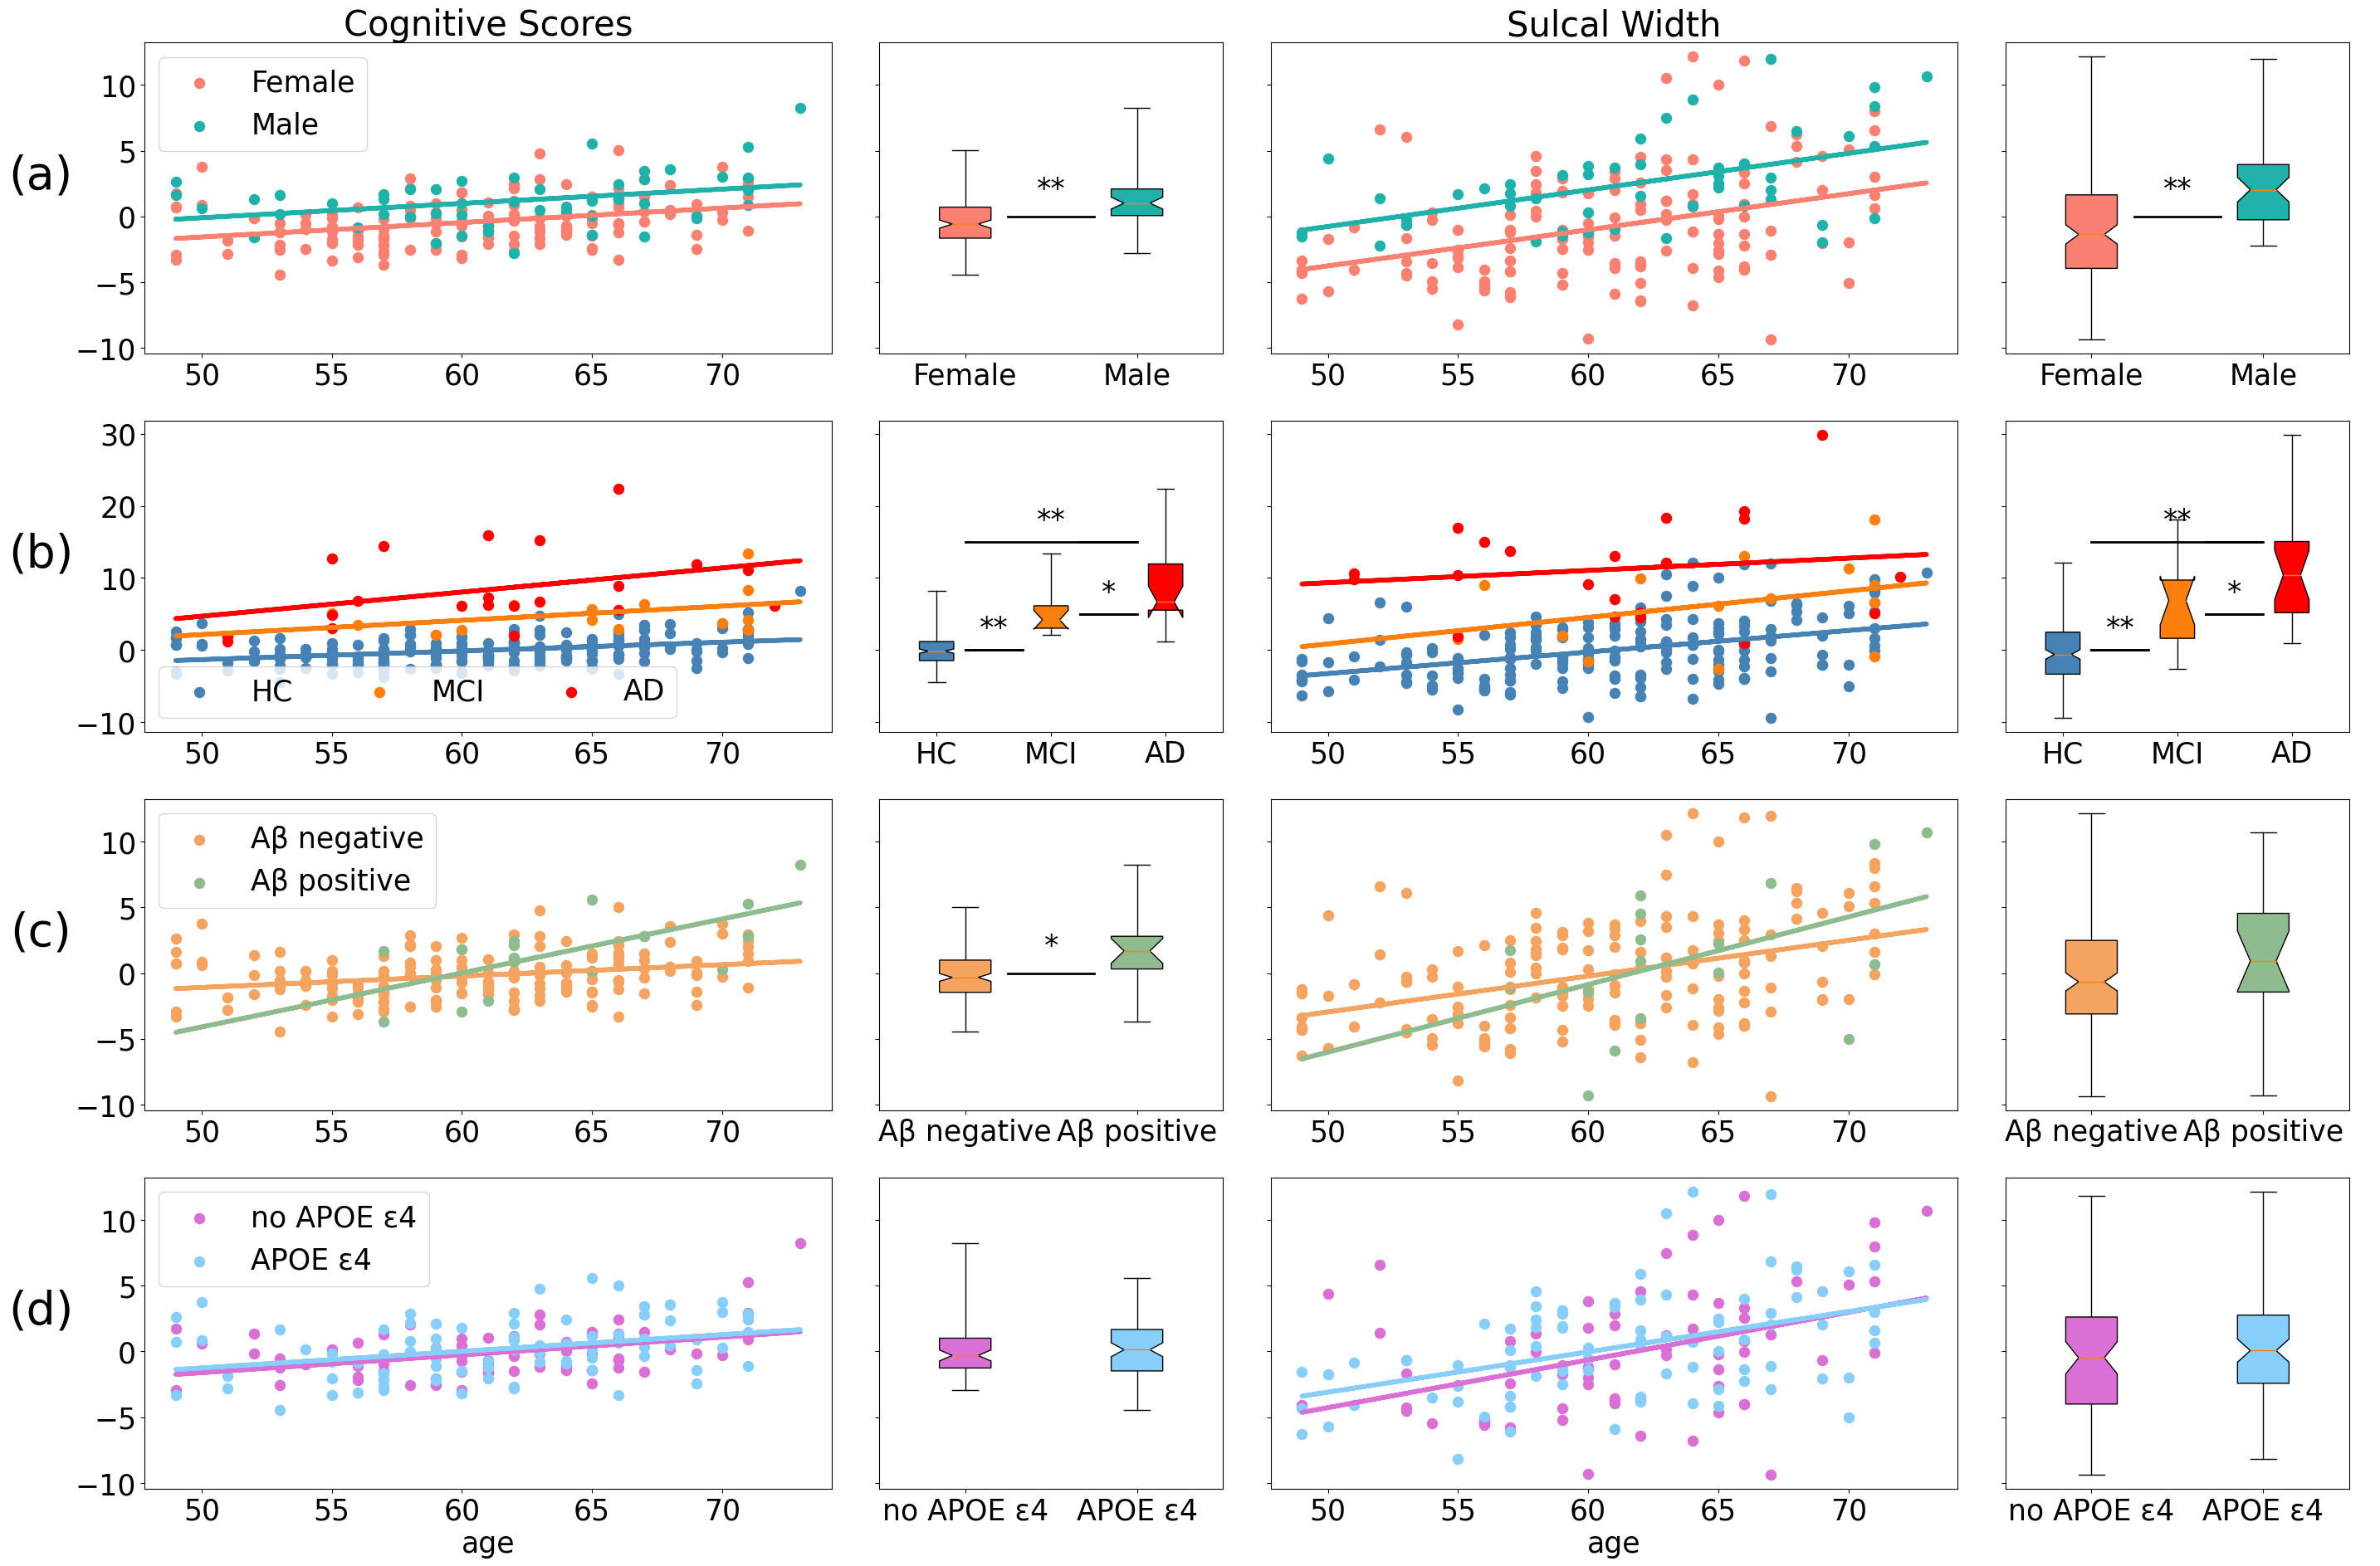

In [18]:
pipeline.fit(Xbrain, Ycogn)
Xbrain_r, Ycogn_r = pipeline.transform(df_brain, df_cogn)
mode = 0
fig = plot_age_effect(Xbrain_r[:, mode], Ycogn_r[:, mode], df_info)

# 4. Is the specific composition of these modes implicitly optimized to covary with age? Are the features identified by performing PLS on the healthy participants optimized to identify out-of-sample clinical participants (MCI/AD)?

## Features permutation tests

In [19]:
mode = 0
nperm = 1000 # number of permutations
pipeline.fit(Xbrain, Ycogn)
Xbrain_r, Ycogn_r = pipeline.transform(df_brain, df_cogn)

np.random.seed(0)
nperm = 1000
Xbrain_perm = np.zeros([nperm, len(Xbrain_r)])
Ycogn_perm = np.zeros([nperm, len(Ycogn_r)])
for perm in range(nperm):
    X = df_brain
    Y = df_cogn
    if pipeline.Ximputer is not None:
        X = pipeline.Ximputer.transform(X)
    if pipeline.Yimputer is not None:
        Y = pipeline.Yimputer.transform(Y)

    # Scaling
    X = pipeline.Xscaler.transform(X)
    Y = pipeline.Yscaler.transform(Y)

    # Permutation
    np.random.shuffle(np.transpose(X))
    np.random.shuffle(np.transpose(Y))
    
    Xperm, Yperm = pipeline.PLS.transform(X, Y)
    Xbrain_perm[perm] = Xperm[:, mode]
    Ycogn_perm[perm] = Yperm[:, mode]

## Plot results

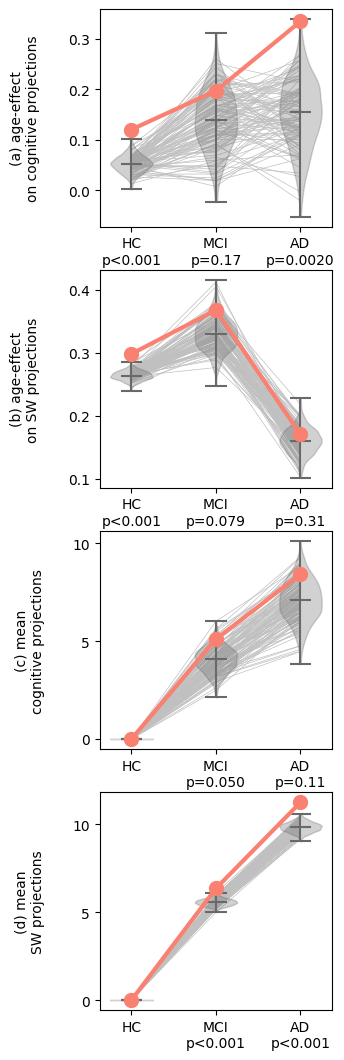

In [20]:
plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(4, 1, figsize=(3, 13))
nperm = len(Xbrain_perm)
for row in range(4):
    ref_score = np.zeros(3)
    scores = np.zeros([len(Xbrain_perm), 3])
    pvals = []
    for g in range(3):
        if row == 3:
            ref_score[g] = np.mean(Xbrain_r[df_info[group_col] == g+1,mode])
            for perm in range(nperm):
                scores[perm, g] = np.mean(Xbrain_perm[perm, df_info[group_col] == g+1])
        elif row == 2:
            ref_score[g] = np.mean(Ycogn_r[df_info[group_col] == g+1,mode])
            for perm in range(nperm):
                scores[perm, g] = np.mean(Ycogn_perm[perm, df_info[group_col] == g+1])
        elif row == 1:
            linreg = stats.linregress(df_info.loc[df_info[group_col] == g+1, 'Age'], 
                                      Xbrain_r[df_info[group_col] == g+1,mode])
            ref_score[g] = linreg.slope
            for perm in range(nperm):
                linreg = stats.linregress(df_info.loc[df_info[group_col] == g+1, 'Age'], 
                                          Xbrain_perm[perm, df_info[group_col] == g+1])
                scores[perm, g] = linreg.slope
        else:
            linreg = stats.linregress(df_info.loc[df_info[group_col] == g+1, 'Age'], 
                                      Ycogn_r[df_info[group_col] == g+1,mode])
            ref_score[g] = linreg.slope
            for perm in range(nperm):
                linreg = stats.linregress(df_info.loc[df_info[group_col] == g+1, 'Age'], 
                                          Ycogn_perm[perm, df_info[group_col] == g+1])
                scores[perm, g] = linreg.slope
        pvals.append((sum(scores[:,g] >= ref_score[g]))/nperm)
    ax = axes[row]
    for perm in range(100):
        ax.plot([1,2,3], scores[perm], color='silver', alpha=1, 
                linewidth=0.5, zorder=1)
    color = 'salmon'
    ax.plot([1,2,3], ref_score, color=color, alpha=1, linewidth=3, zorder=3)
    ax.plot(range(1, 3+1), ref_score, color=color, marker='o', markersize=10, zorder=3)
    ax.set_xticks(range(1, 3+1))
    xticklabels = [f'HC\np{print_pval(pvals[0])}',
                    f'MCI\np{print_pval(pvals[1])}', 
                    f'AD\np{print_pval(pvals[2])}']
    if row in [2, 3]:
        xticklabels[0] = 'HC'
    ax.set_xticklabels(xticklabels)
    v = ax.violinplot(scores, showmedians=True)
    for pc in v['bodies']:
        pc.set_zorder(2)
        pc.set_color('dimgrey')
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = v[partname]
        vp.set_edgecolor('dimgrey')
axes[0].yaxis.labelpad = 20
axes[0].set_ylabel('(a) age-effect\non cognitive projections')
axes[1].yaxis.labelpad = 20
axes[1].set_ylabel('(b) age-effect\non SW projections')
axes[2].yaxis.labelpad = 20
axes[2].set_ylabel('(c) mean\ncognitive projections')
axes[3].yaxis.labelpad = 20
axes[3].set_ylabel('(d) mean\nSW projections')
axes[0].set_yticks([0,0.1,0.2,0.3])
axes[1].set_yticks([0.1,0.2,0.3,0.4])
axes[2].set_yticks([0,5,10])
axes[3].set_yticks([0,5,10])

# 5. Sulci loadings comparison

## Loading data

In [21]:
df_brain1 = pd.read_csv('/home/leonie/Documents/data/pisa/sMRI/sulci_morphometry_measurements/per_measurement/opening.csv', index_col=0)
df_cogn1 = pd.read_csv('/home/leonie/Documents/data/pisa/cognitive_scores/neuropsych.csv', index_col=0)
df_info1 = pd.read_csv('/home/leonie/Documents/data/pisa/cognitive_scores/demographics.csv', index_col=0)
regress_out_confounds1 = False
train_hc_only1 = True

df_brain2 = pd.read_csv('/home/leonie/Documents/data/pisa/sMRI/sulci_morphometry_measurements/per_measurement/opening.csv', index_col=0)
df_cogn2 = pd.read_csv('/home/leonie/Documents/data/pisa/cognitive_scores/neuropsych.csv', index_col=0)
df_info2 = pd.read_csv('/home/leonie/Documents/data/pisa/cognitive_scores/demographics.csv', index_col=0)
regress_out_confounds2 = True
train_hc_only2 = False

mode = 0
figure_folder = '/tmp'
nboot = 1000

## Compare loadings

In [22]:
remove_missing = True
downsampling = True
mean = True
cogn_startswith = None

boostx = []
for df_brain, df_cogn, df_info, regress_out_confounds, train_hc_only in zip(
        [df_brain1, df_brain2], [df_cogn1, df_cogn2], [df_info1, df_info2],
        [regress_out_confounds1, regress_out_confounds2],
        [train_hc_only1, train_hc_only2]):
    dfb, dfc, dfi, Xbrain, Ycogn = functions.preprocessing.preprocessing(
        df_brain, df_cogn, df_info, 
        group_col=group_col, age_col=age_col, sex_col=sex_col,
        drop_rate=drop_rate, regress_out_confounds=regress_out_confounds,
        train_hc_only=train_hc_only, mean=mean, verbose=False)
    np.random.seed(0)
    x_loadings = []
    for i in range(nboot):
        Xr, Yr = resample(Xbrain, Ycogn)
        Xrt, Yrt = pipeline.fit_transform(Xr, Yr)
        x_loadings.append(pipeline.PLS.x_loadings_)
    boostx.append(np.array(x_loadings))

# correlations
corr = np.corrcoef([np.array(boostx[i]).mean(axis=0)[:, 0] for i in range(2)])
print(f'Loadings correlation: {corr[0,1]}')

Loadings correlation: 0.949688405551364


## Snapshots

In [23]:
sc = np.array(boostx[0]).mean(axis=0)[:, mode] - np.array(boostx[1]).mean(axis=0)[:, mode]
dict_sulcus = {s+'_left': x for s,x in zip(Xbrain.columns, sc) if s!=0}
for s in Xbrain.columns:
    dict_sulcus[s+'_left'] = dict_sulcus[s+'_left']
dict_reg = {0 : [0.5, -0.5, -0.5, 0.5], 1 : [0.5, 0.5, 0.5, 0.5]}
for side in ['left']:
    for reg in [0, 1]:
        sfile = os.path.join(figure_folder, f'brain1-brain2_{side}{reg}.png')
        functions.snapshots.view_sulcus_scores(
            dict_sulcus, side=side, reg_q=dict_reg[reg],
            minVal=-0.07, maxVal=0.07, snapshot=sfile)
        print(f'Snapshot saved at {sfile}\n')

XSOCK=/tmp/.X11-unix && XAUTH=/tmp/.docker.xauth && xauth nlist :0 | sed -e 's/^..../ffff/' | xauth -f $XAUTH nmerge - && docker run --rm -v /tmp//brain1-brain2_left0.csv:/home//brain1-brain2_left0.csv:  -v /tmp:/home/snapshot: -v $XSOCK:$XSOCK -v $XAUTH:$XAUTH -e XAUTHORITY=$XAUTH 9051257e588b /bin/bash -c ". /home/brainvisa/build/bug_fix/bin/bv_env.sh /home/brainvisa/build/bug_fix && python ./snapshots.py -c /home//brain1-brain2_left0.csv -o /home/snapshot/brain1-brain2_left0.png -s left -r 0 -p 'Blue-Red-fusion' -b white -m -0.07 -n 0.07"

Snapshot saved at /tmp/brain1-brain2_left0.png

XSOCK=/tmp/.X11-unix && XAUTH=/tmp/.docker.xauth && xauth nlist :0 | sed -e 's/^..../ffff/' | xauth -f $XAUTH nmerge - && docker run --rm -v /tmp//brain1-brain2_left1.csv:/home//brain1-brain2_left1.csv:  -v /tmp:/home/snapshot: -v $XSOCK:$XSOCK -v $XAUTH:$XAUTH -e XAUTHORITY=$XAUTH 9051257e588b /bin/bash -c ". /home/brainvisa/build/bug_fix/bin/bv_env.sh /home/brainvisa/build/bug_fix && python ./snaps

## Histogram

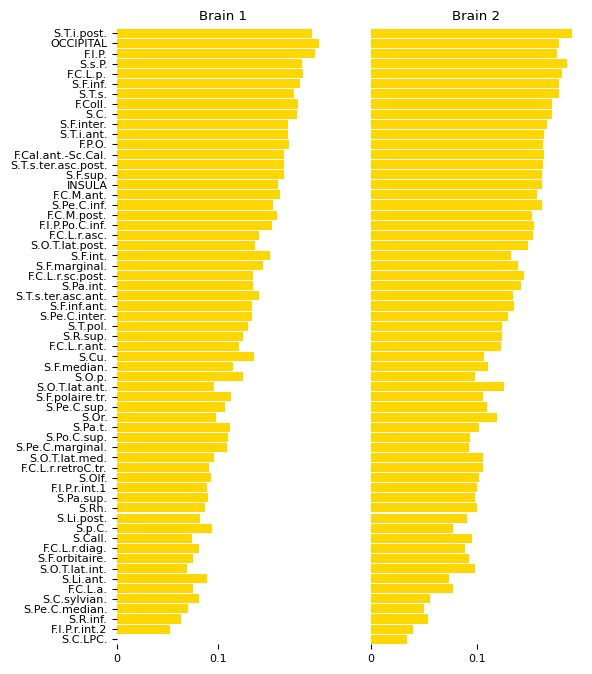

In [24]:
means = np.array(boostx).mean(axis=0).mean(axis=0)[:,0]
labels = Xbrain.columns
labels = [l for m, l in sorted(zip(means, labels))]

titles = ['Brain 1', 'Brain 2']
plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(1, 2, figsize=(6, 8))
for i in range(2):
    ax = axes[i]
    x_loadings = np.array(boostx)[i]
    means_db = [m if up*down > 0 else 0 for m, up, down in zip(
        np.mean(x_loadings, axis=0)[:, mode],
        np.percentile(x_loadings, 97.5, axis=0)[:, mode],
        np.percentile(x_loadings, 2.5, axis=0)[:, mode])]
    probas = [p for m,p in sorted(zip(means, means_db))]
    ax.barh(range(len(labels)), probas, 0.9, color='gold', align='center')
    ax.set_ylim(-0.5, len(labels)-0.5)
    ax.set_yticks([])
    ax.set_xticks([0, 0.1])
    ax.set_xticklabels([0, 0.1])
    ax.set_title(titles[i])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
axes[0].set_yticks(range(len(labels)))
_ = axes[0].set_yticklabels(labels)

# 6. Which projection performs a better differentiation healthy from clinical participants?

## Functions definition

In [25]:
# projection computation function
def compute_lv(df_brain, df_cogn, df_info, pipeline, train=None):
    dfb, dfc, dfi, Xbrain, Ycogn = functions.preprocessing.preprocessing(
        df_brain, df_cogn, df_info, 
        group_col=group_col, age_col=age_col, sex_col=sex_col,
        drop_rate=drop_rate, regress_out_confounds=False,
        train_hc_only=True, mean=True, verbose=False)
    
    if train is None:
        pipeline.fit(Xbrain, Ycogn)
    else:
        df_train = dfi.iloc[train]
        df_train_hc = df_train[df_train[group_col] == 1]
        pipeline.fit(Xbrain.loc[df_train_hc.index], Ycogn.loc[df_train_hc.index])
    Xsulci_r, Ycogn_r = pipeline.transform(dfb, dfc)
    return Xsulci_r[:,mode], Ycogn_r[:,mode], dfi[group_col]

# figure functions
def scatter_plot(df_brain, df_cogn, df_info, pipeline, 
                 df_brain2=None, lv1_name='LV1', lv2_name='LV2'):
    if df_brain2 is None:
        lv1, lv2, gr = compute_lv(df_brain, df_cogn, df_info, pipeline)
    else:
        lv1, _, gr = compute_lv(df_brain, df_cogn, df_info, pipeline)
        lv2, _, _ = compute_lv(df_brain2, df_cogn, df_info, pipeline)
    left, width = 0.1, 0.8
    bottom, height = 0.1, 0.8
    spacing = 0.005
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]
    # start with a square Figure
    plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize=(6, 6))    
    ax = fig.add_axes(rect_scatter)
    # ax.set_yticks([-8,-4,0,4])
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histx.axis('off')
    ax_histy = fig.add_axes(rect_histy, sharey=ax)
    ax_histy.axis('off')
    # main scatter plot
    col={1:'steelblue', 2:'tab:orange', 3:'red'}
    dict_label={1:'HC', 2:'MCI', 3:'AD'}
    for i in set(gr):
        ax.scatter(lv1[gr == i], lv2[gr == i],
                   label=dict_label[i], marker="o", c=col[i], s=75)
    ax.legend()
    ax.set_xlabel(lv1_name)
    ax.set_ylabel(lv2_name)    
    # histogram
    for i in set(gr):
        h2 = sns.kdeplot(y = lv2[gr == i],
                         fill = True, linewidth = 3, 
                         ax = ax_histy, color=col[i])
        h1 = sns.kdeplot(x = lv1[gr == i],
                         shade = True, linewidth = 3, 
                         ax = ax_histx, color=col[i])

def auc_plot(df_brain, df_cogn, df_info, pipeline, 
             df_brain2=None, lv1_name='LV1', lv2_name='LV2'): 
    lw=3
    if df_brain2 is None:
        lv1, lv2, gr = compute_lv(df_brain, df_cogn, df_info, pipeline)
    else:
        lv1, _, gr = compute_lv(df_brain, df_cogn, df_info, pipeline)
        lv2, _, _ = compute_lv(df_brain2, df_cogn, df_info, pipeline)
    y = np.array([0 if g==1 else 1 for g in gr])
    fig, axes = plt.subplots(1, 3, figsize=(13, 7), sharex=True, sharey=True)
    for X, title, ax in zip([np.array([lv1]).T, np.array([lv2]).T, 
                             np.array([lv1, lv2]).T],
                            [lv1_name, lv2_name, f'{lv1_name} & {lv2_name}'], axes):
        random_state = np.random.RandomState(0)
        cv = StratifiedKFold(n_splits=10)
        classifier = svm.SVC(kernel='linear', probability=True,
                             random_state=random_state)
        
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        
        for i, (train, test) in enumerate(cv.split(X, y)):
            if df_brain2 is None:
                train_lv1, train_lv2, _ = compute_lv(
                    df_brain, df_cogn, df_info, pipeline, train)
            else:
                train_lv1, _, _ = compute_lv(
                    df_brain, df_cogn, df_info, pipeline, train)
                train_lv2, _, _ = compute_lv(
                    df_brain2, df_cogn, df_info, pipeline, train) 
            if title == lv1_name:
                X = np.array([train_lv1]).T
            elif title == lv2_name:
                X = np.array([train_lv2]).T
            else:
                X = np.array([train_lv1, train_lv2]).T
            classifier.fit(X[train], y[train])
            viz = plot_roc_curve(classifier, X[test], y[test],
                                  alpha=0, lw=lw, ax=ax)
            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)
        
        ax.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='r',
                label='Chance', alpha=.8)
        
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        ax.plot(mean_fpr, mean_tpr, color='b',
                label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                lw=lw, alpha=.8)
        
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label=r'$\pm$ 1 std. dev.')
        
        ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
        ax.get_legend().remove()
        ax.set_title(f'{title}\n(AUC={mean_auc:.2f} std. {std_auc:.2f})')
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_xticks([0,0.5,1])
    
    axes[1].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')

## Brain projection vs. Cognitive projections

In [26]:
df_brain = pd.read_csv('/home/leonie/Documents/data/pisa/sMRI/sulci_morphometry_measurements/per_measurement/opening.csv', index_col=0)
df_cogn = pd.read_csv('/home/leonie/Documents/data/pisa/cognitive_scores/neuropsych.csv', index_col=0)
df_info = pd.read_csv('/home/leonie/Documents/data/pisa/cognitive_scores/demographics.csv', index_col=0)

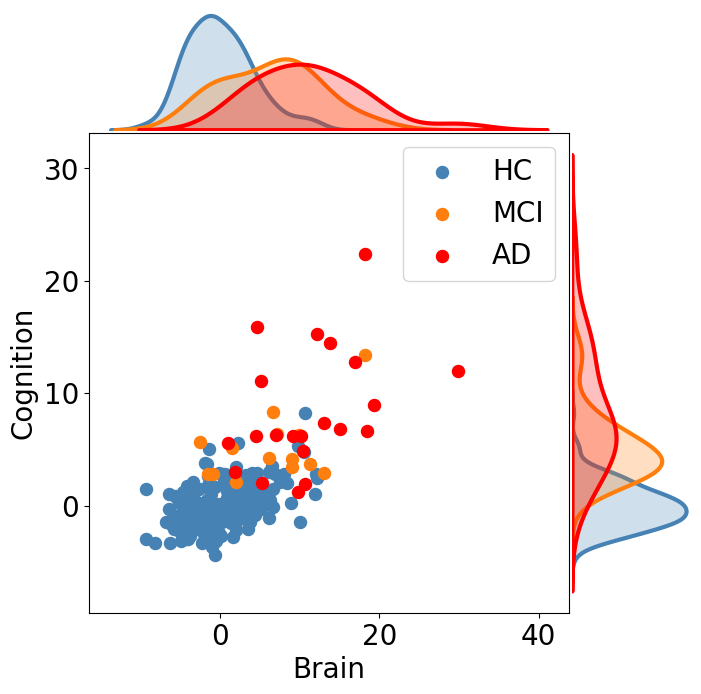

In [27]:
scatter_plot(df_brain, df_cogn, df_info, pipeline, lv1_name='Brain', lv2_name='Cognition')

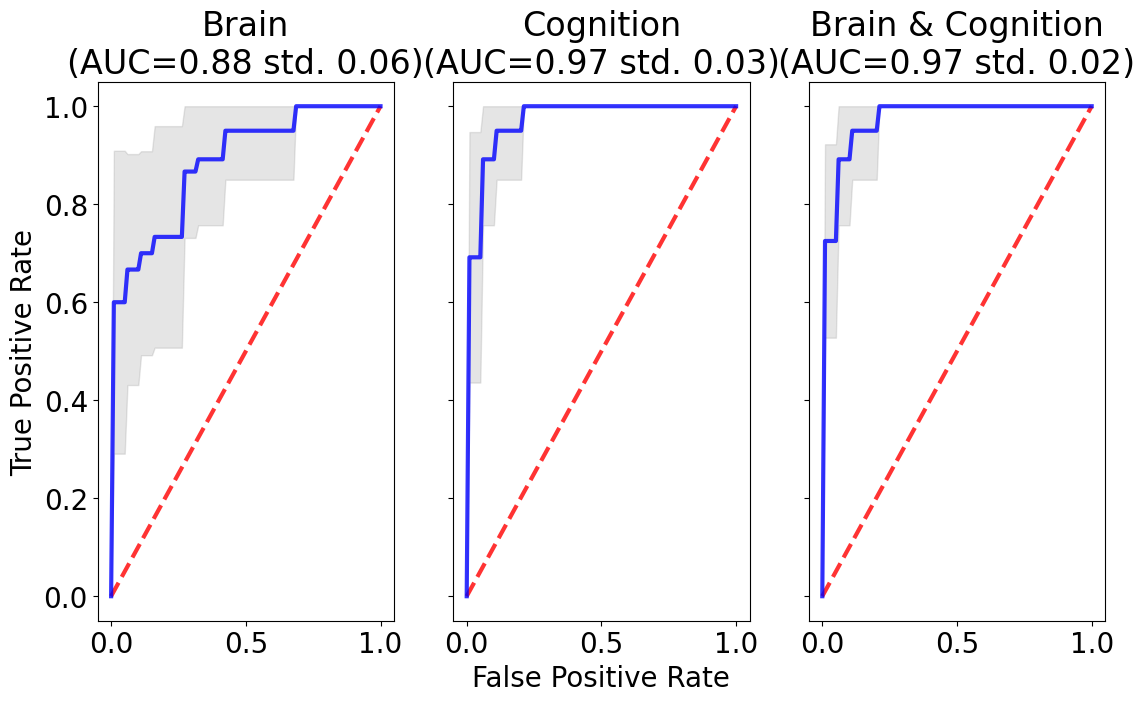

In [28]:
auc_plot(df_brain, df_cogn, df_info, pipeline, lv1_name='Brain', lv2_name='Cognition')

## Brain 1 vs. Brain 2 projections

In [29]:
df_brain2 = pd.read_csv('/home/leonie/Documents/data/pisa/cognitive_scores/hippocampal_volume.csv', index_col=0)

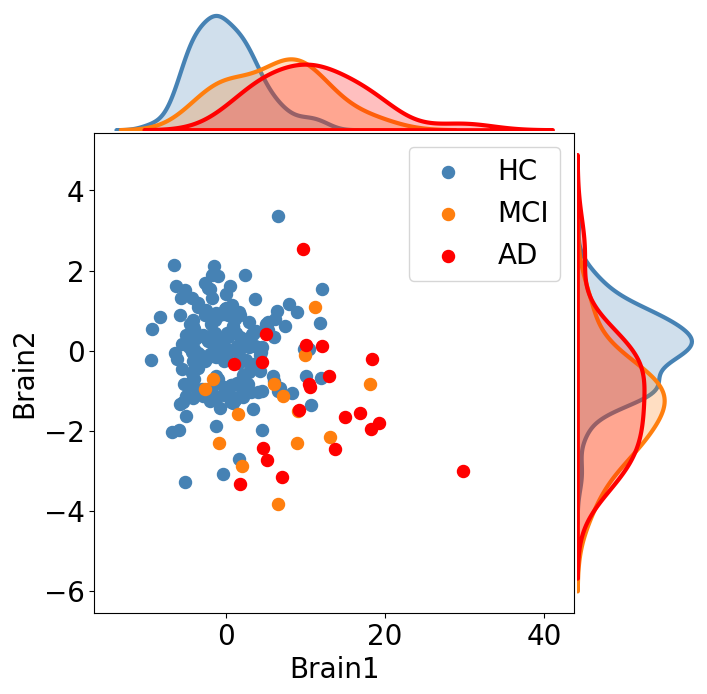

In [30]:
scatter_plot(df_brain, df_cogn, df_info, pipeline, df_brain2, lv1_name='Brain1', lv2_name='Brain2')

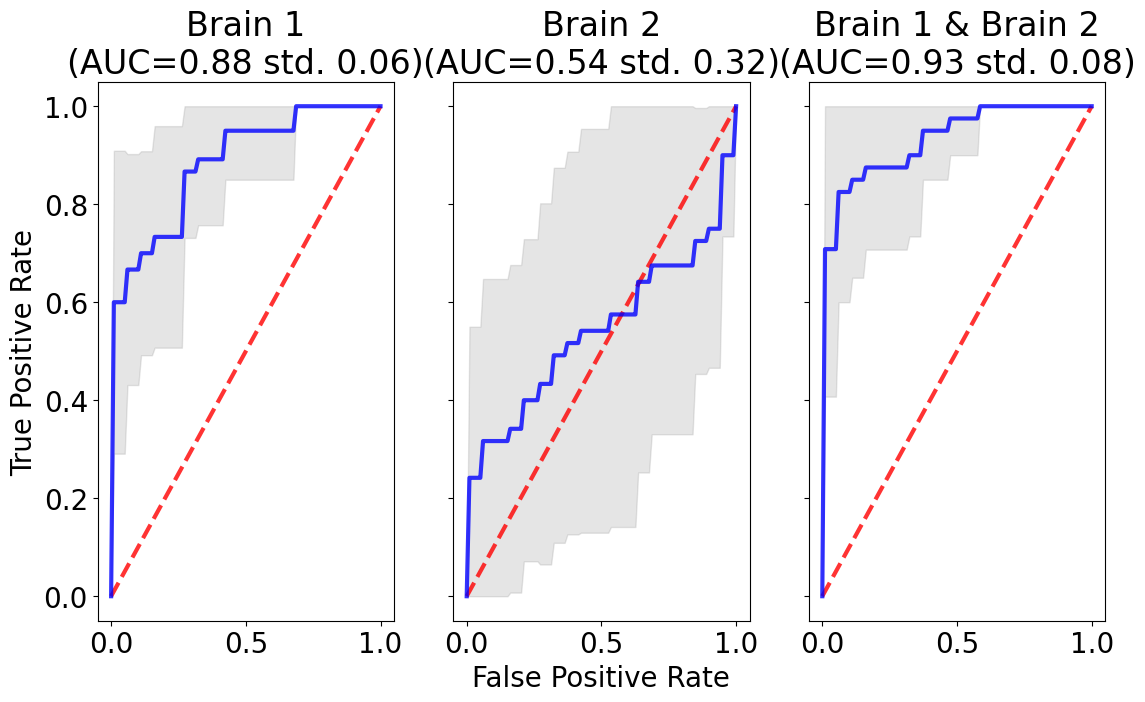

In [31]:
auc_plot(df_brain, df_cogn, df_info, pipeline, df_brain2, lv1_name='Brain 1', lv2_name='Brain 2')